<a href="https://colab.research.google.com/github/katty-anay/Fluid_mechanics_/blob/main/Report_Navier-Stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Navier-Stokes equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Navier-Stokes equations for Unsteady flow, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [1]:
# This program has been written with a template from
# DD2365 Advanced Computation in Fluid Mechanics,
# KTH Royal Institute of Technology, Stockholm, Sweden.

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This report has been written by Katty Raboanarijaona (20021105-T545)

# **Set up environment**

In [2]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

--2025-04-27 14:29:54--  https://fem-on-colab.github.io/releases/fenics-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4180 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.08K  --.-KB/s    in 0s      

2025-04-27 14:29:54 (19.6 MB/s) - ‘/tmp/fenics-install.sh’ saved [4180/4180]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/d7ddd552/releases/pybi

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula:

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization,

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder).

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

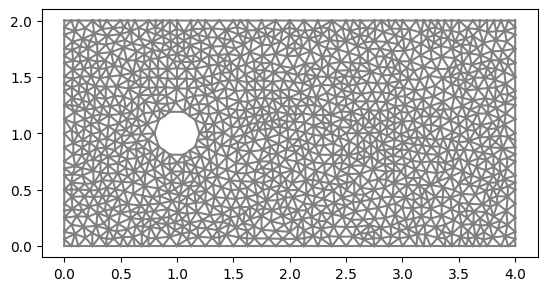

In [3]:
# Define rectangular domain
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.2
D=2*rc

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [4]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00552297 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.840085 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00164437 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0115891 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

**Define boundary conditions**

In [5]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Inflow conditions
uin = 1.0
U=1.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pout = 0.0
bcp1 = DirichletBC(Q, pout, dbc_right)

bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# **Results**

**Define flow parameters**

In [6]:
# Set viscosity
Re=100 #(test for Re=1,10,100,1000)
nu = (D*U)/Re

**Define method parameters**

In [7]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and lienar solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.5*mesh.hmin()

**Define variational problem**

In [8]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx
ap = lhs(Fp)
Lp = rhs(Fp)

**Triple decomposition**

In [9]:
import scipy.linalg.lapack as la
import numpy as np

def triple_decomposition(grad_u):
    new_grad = np.array([[0,0,0],
                         [0,0,0],
                         [0,0,0]])
    for i in range(2):
      for j in range(2):
        new_grad[i,j] = grad_u[i,j]
    def dselect(arg1,arg2): return (arg2==0)
    T = la.dgees(dselect,new_grad,sort_t = 1)[0]
    sh = np.linalg.norm([T[0,1],T[0,2],T[1,2]+T[2,1]])
    el = np.linalg.norm(np.diag(T))
    rr = np.sqrt(2*min(abs(T[1,2]),abs(T[2,1]))**2)
    return sh, el, rr

**Compute force on boundary**

In [10]:
# Direction - drag force
#phi_x = 1.0
#phi_y = 0.0

# Direction - lift force
#phi_x = 0.0
#phi_y = 1.0

# For the drag
phi_x = 1.0
phi_y = 0.0
psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi = interpolate(psi_expression, V)

drag = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

# For the lift
phi_x = 0.0
phi_y = 1.0
psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi = interpolate(psi_expression, V)

lift = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

# Force normalization
D = 2*rc
normalization = -2.0/D

**Set plotting variables and open export files**

In [11]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 10

# Force computation data
drag_array = np.array(0.0)
drag_array = np.delete(drag_array, 0)
lift_array = np.array(0.0)
lift_array = np.delete(lift_array, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

In [ ]:
!rm results-NS/*

# Time stepping
T = 30
t = dt
while t < T + DOLFIN_EPS:

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble momentum matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap)
        bp = assemble(Lp)

        # Compute pressure solution
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        Drag = assemble(drag)
        Lift = assemble(lift)
        if (t > start_sample_time):
          drag_array = np.append(drag_array, normalization*Drag)
          lift_array = np.append(lift_array, normalization*Lift)
          time = np.append(time, t)

        k += 1

    if t > plot_time:

        s = 'Time t = ' + repr(t)
        print(s)

        # Save solution to file
        file_u << u1
        file_p << p1

        # Triple decomposition
        V = TensorFunctionSpace(mesh, 'P', 1)
        grad_u1_prel = nabla_grad(u1)
        grad_u1 = project(grad_u1_prel, V)

        V2 = FunctionSpace(mesh, 'CG', 1)
        shear = Function(V2)
        elongation = Function(V2)
        rotation = Function(V2)
        dofmap = V2.dofmap()

        # Divergence
        divu = Function(V2)

        for vertex in vertices(mesh):
            point = vertex.point()
            grad_u1_point = grad_u1(point) # Evaluate the gradient tensor at the current point
            grad_u1_matrix = matrix = np.array([
                                                [grad_u1_point[0],grad_u1_point[1] ],
                                                [grad_u1_point[2], grad_u1_point[3]]
                                                                                       ])
            sh, el, rr = triple_decomposition(grad_u1_matrix)
            vertex_index = vertex.index()
            dof_index = vertex_to_dof_map(V2)[vertex_index]
            shear.vector()[dof_index] = sh
            elongation.vector()[dof_index] = el
            rotation.vector()[dof_index] = rr

            divu_vert = grad_u1_point[0] + grad_u1_point[3]
            divu.vector()[dof_index] = divu_vert

        # Plot Triple Decomposition
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        ax = plt.subplot(1, 3, 1)
        im = plot(shear, title = "Shear")
        plt.colorbar(im)
        ax = plt.subplot(1, 3, 2)
        im = plot(elongation, title = "Strain")
        plt.colorbar(im)
        ax = plt.subplot(1, 3, 3)
        im = plot(rotation, title = "Rotation")
        plt.colorbar(im)
        plt.tight_layout()
        plt.show()

        # Plot divergence
        plt.figure()
        im = plot(divu, title="divergence")
        plt.colorbar(im)

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")

        plot_time += T/plot_freq

        plt.show()

        plt.figure()
        plt.title("Drag coefficient")
        plt.plot(time, drag_array)
        plt.show()

        plt.figure()
        plt.title("Lift coefficient")
        plt.plot(time, lift_array)
        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

#!tar -czvf results-NS.tar.gz results-NS
#files.download('results-NS.tar.gz')

#Here the outputs are hidden. The useful results are gathered in the discussion part.

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle, and for a high enough Reynolds number and sufficient mesh resolution [a von Karman vortex street developed as expected.](https://en.wikipedia.org/wiki/Kármán_vortex_street)

# **1. Reynolds number**



### **Re=1**


At the beginning :
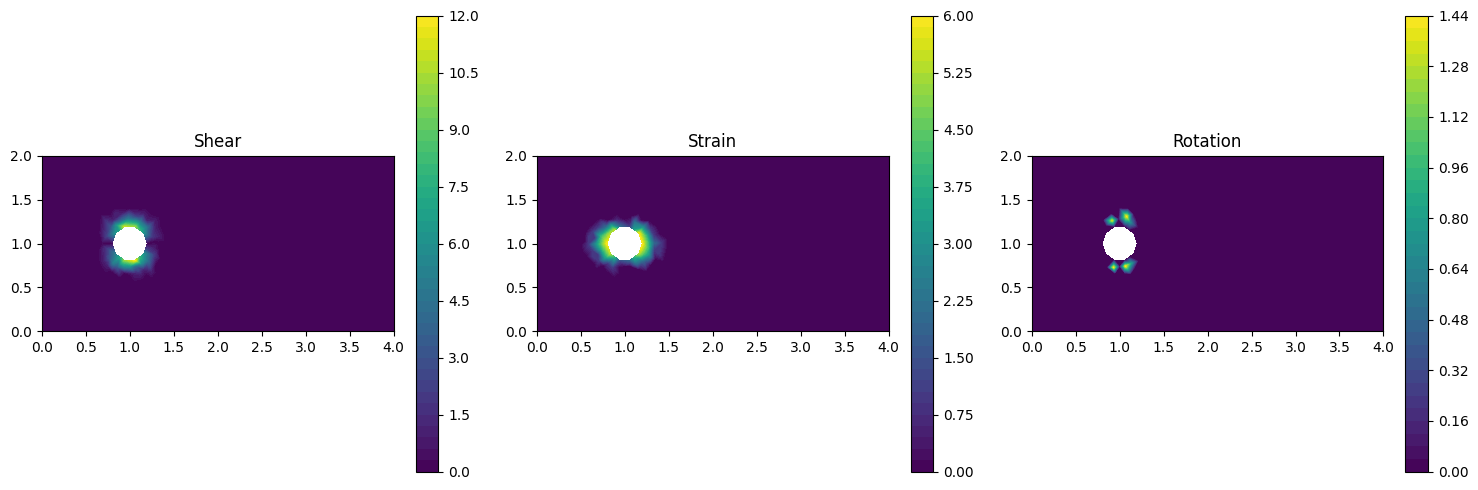

At the end :
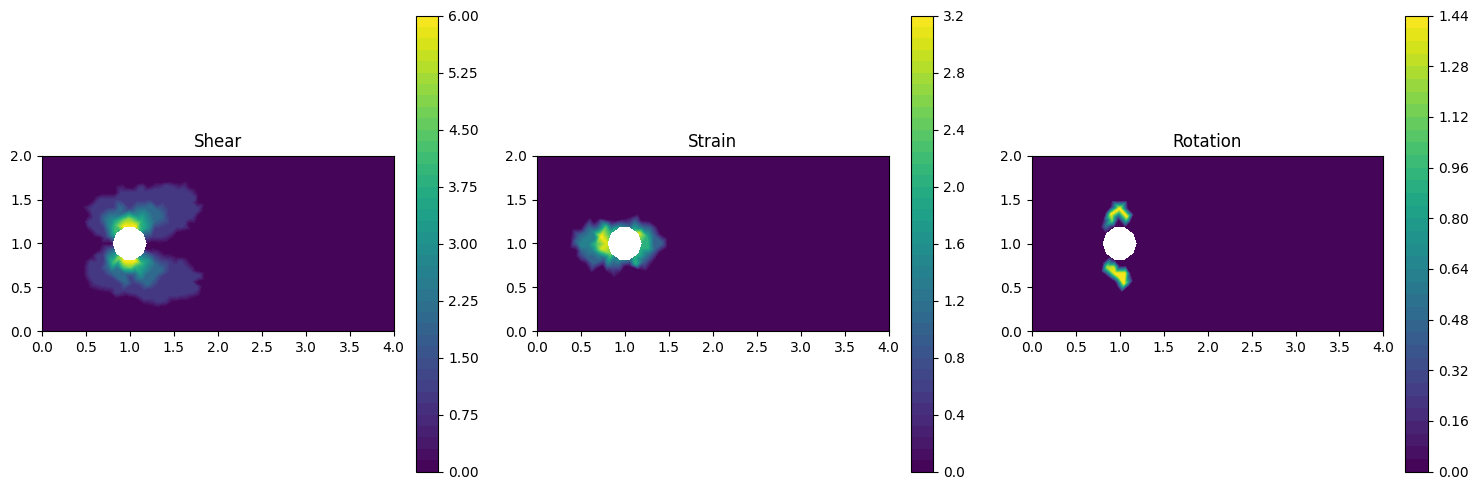

▶ The three flow structures from the triple decomposition are not significantly evolving for very low Re (Re=1).
The shear is the one component that slightly changes during the simulation time.

At the beginning :

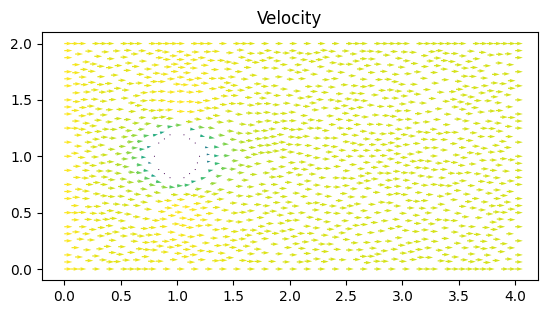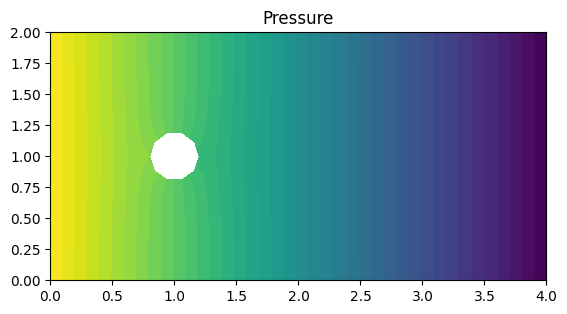

At the end :

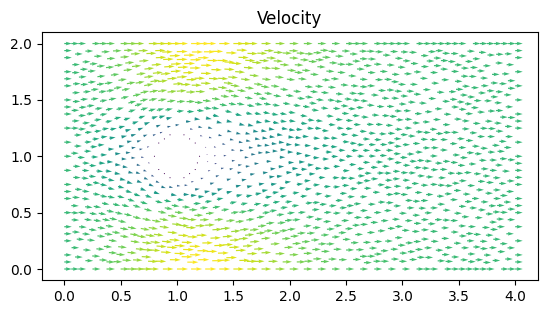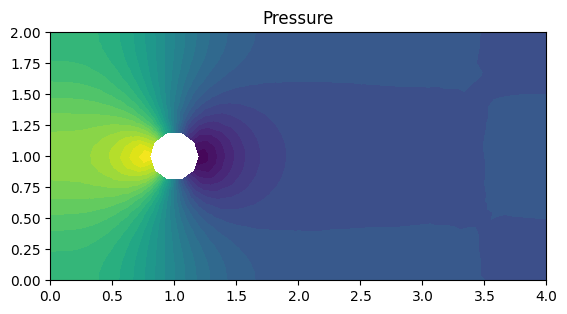

**From the observations, the flow is steady for Re=1.**

### **Re=10**



At the beginning :

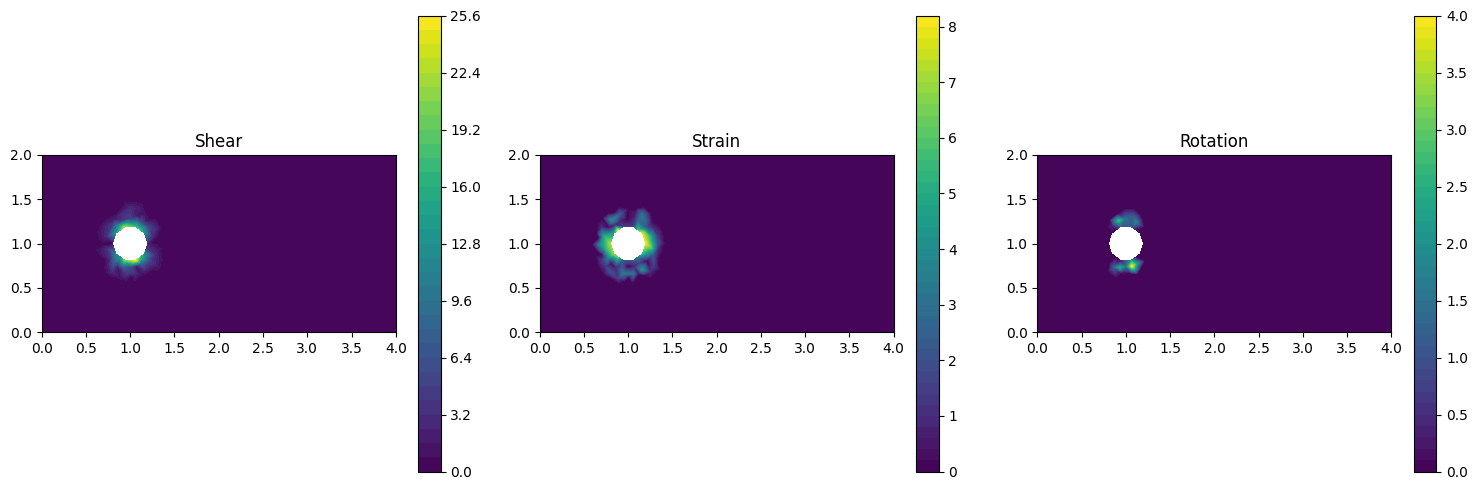

After some time :

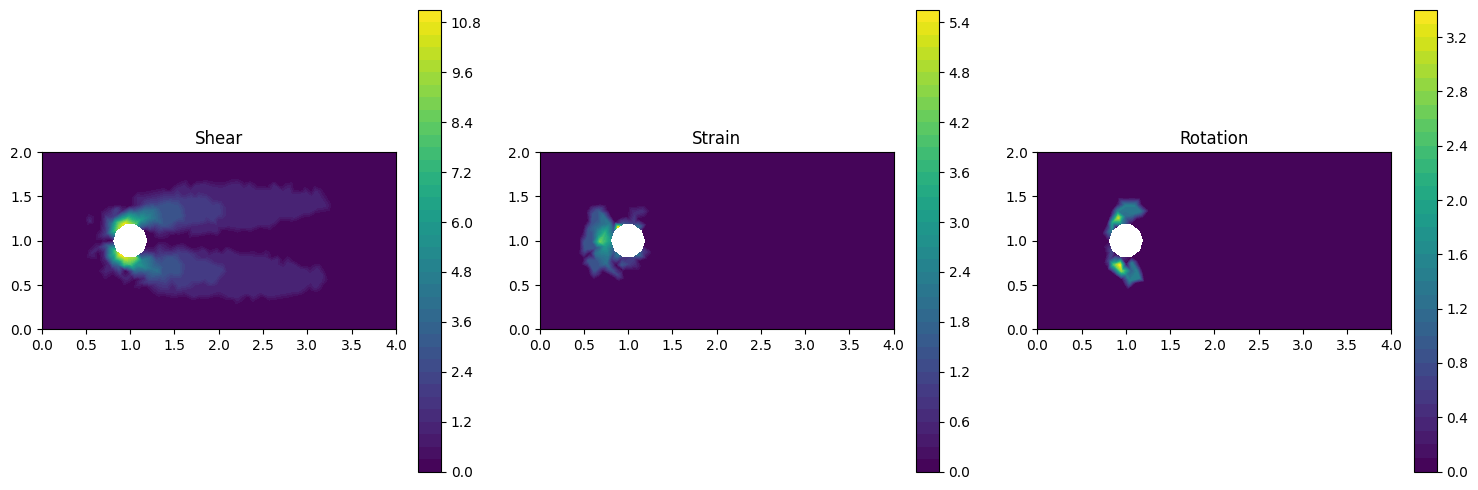

At the end :

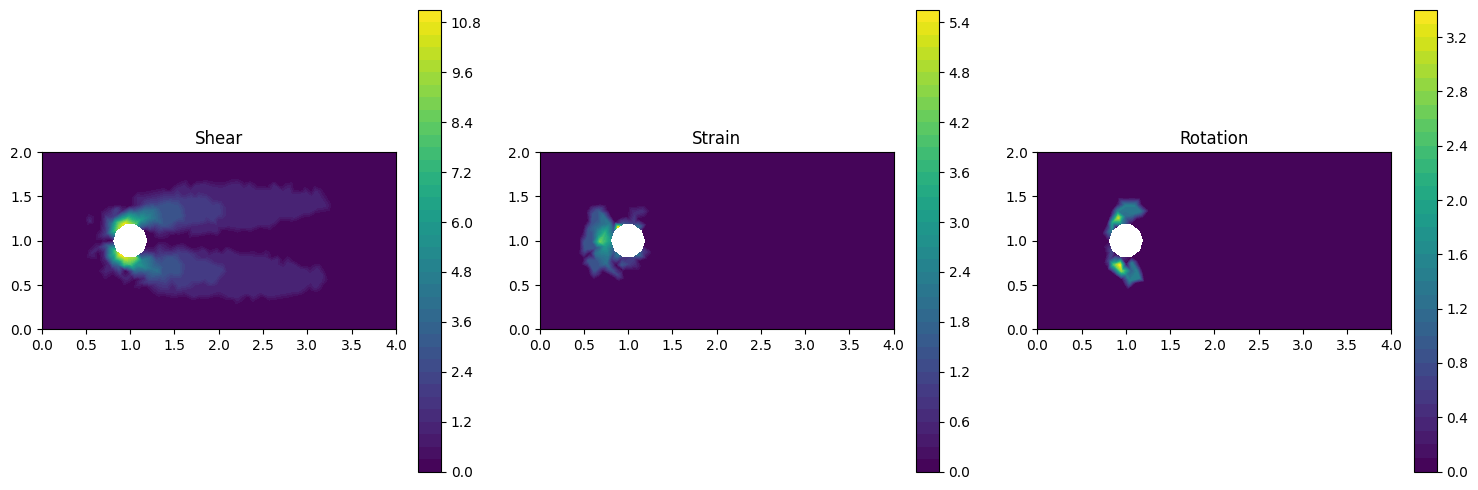

▶ Just as the previous case, for Re=10 the strain and rotation structures are not evolving significantly. The shear is quickly changing but then it keeps the same structure.

At the beginning :

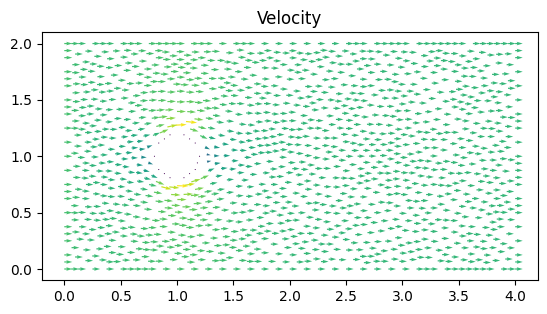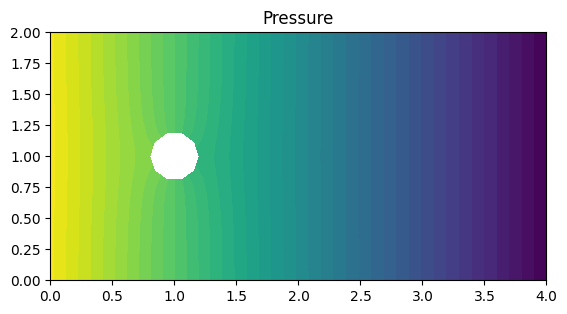

After some time :

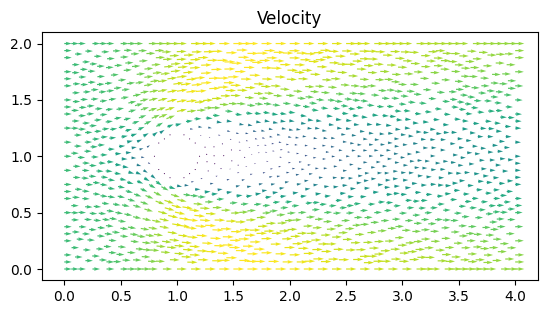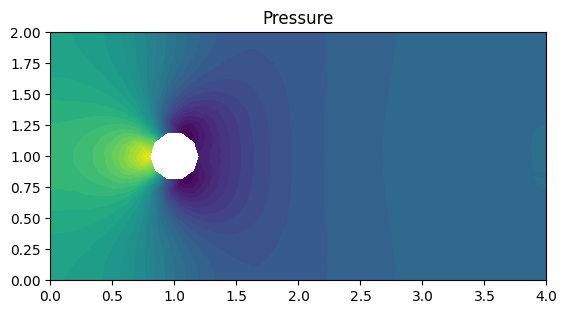

At the end :

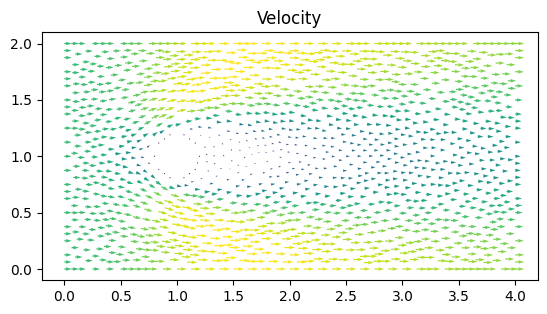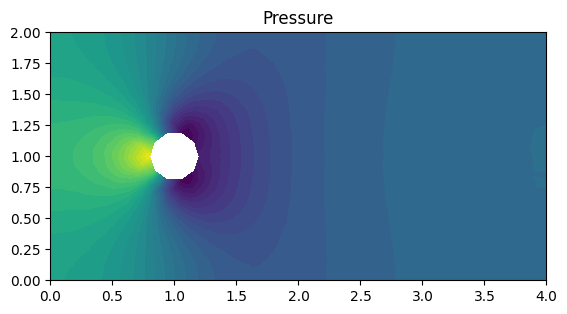

**From the observations, the flow is steady for Re=10.**

### **Re=100**



At the beginning :

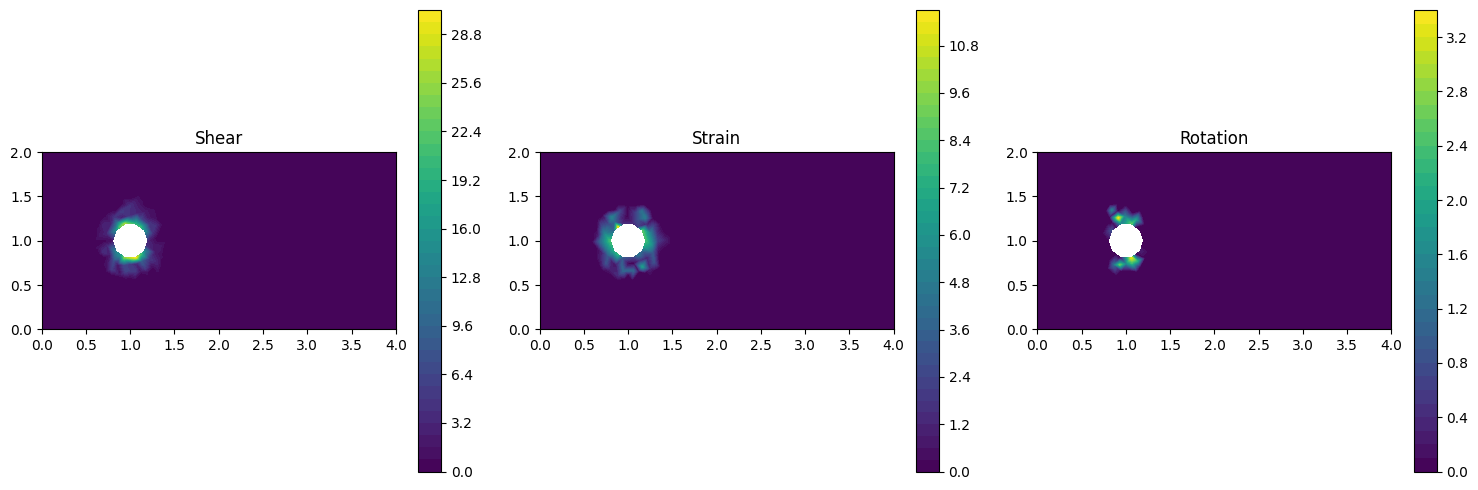

After some time :

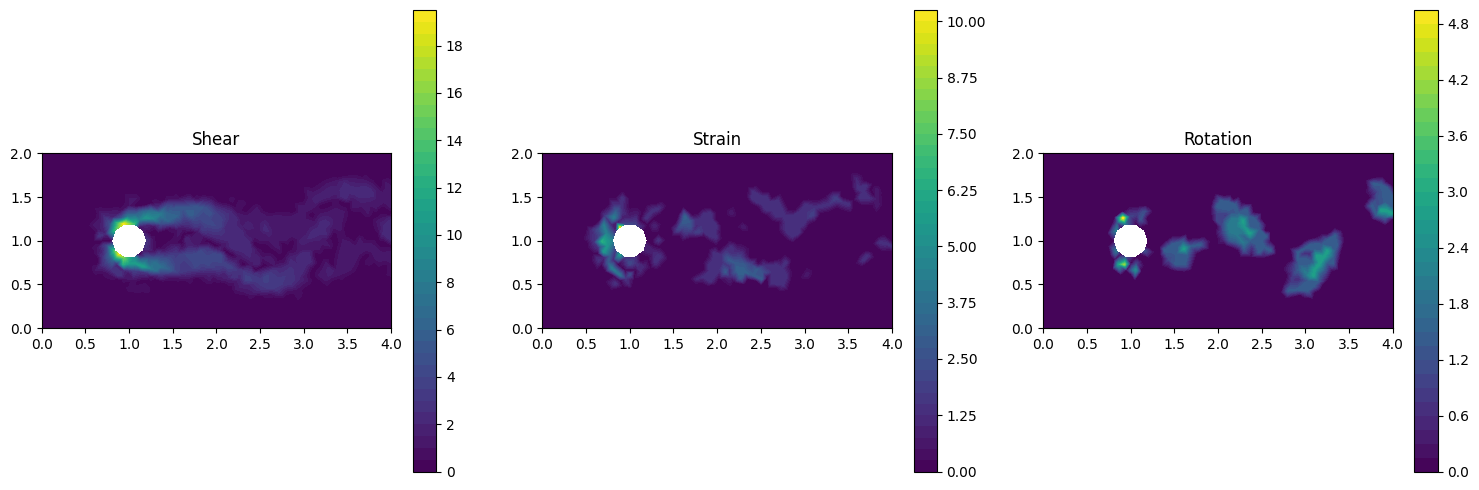

At the end :

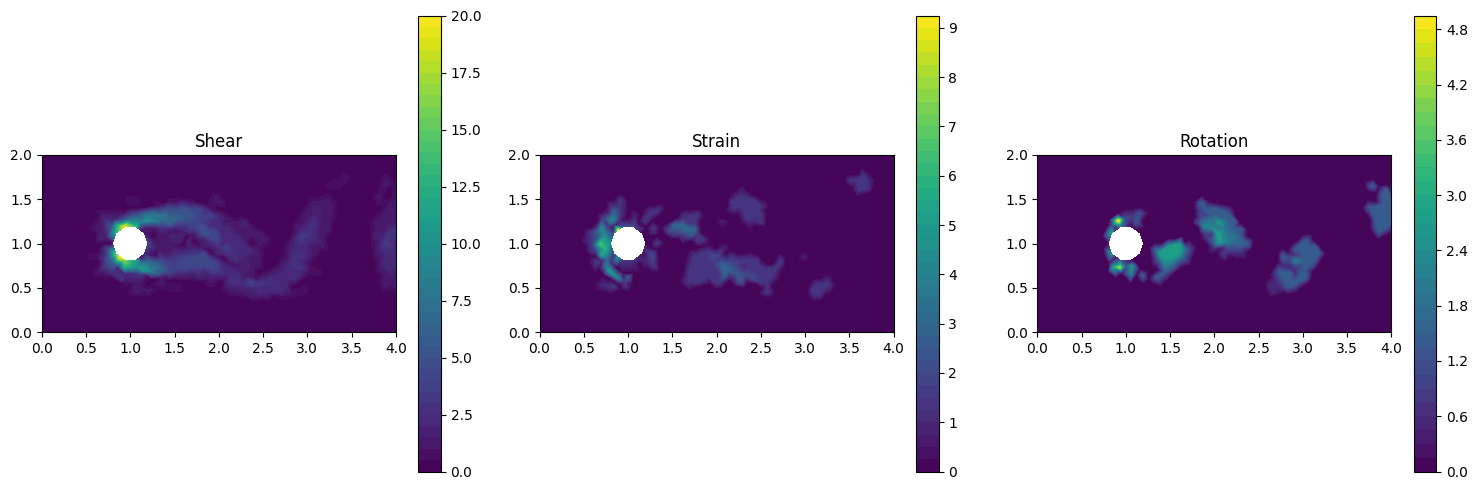

▶ For Re=100, the three structures are significantly evolving. Indeed, the shear forms some elongation around the cylindre, the strain forms some components "behind" in the flow and the rotation represents the vortex we can observe.

At the beginning :

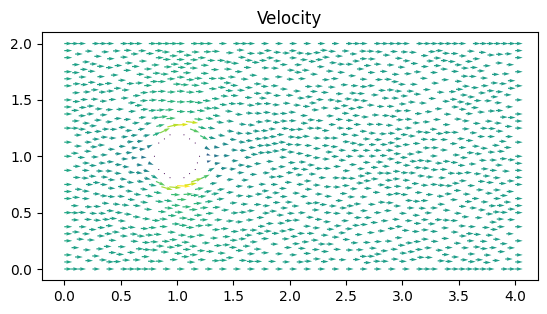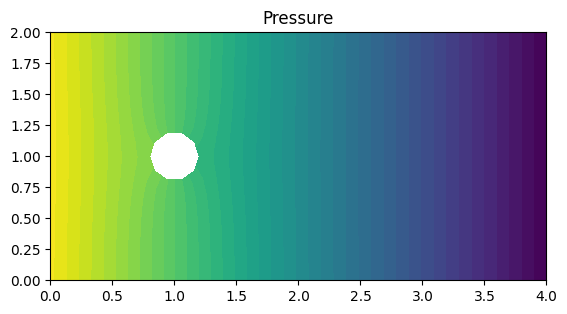

After some time :

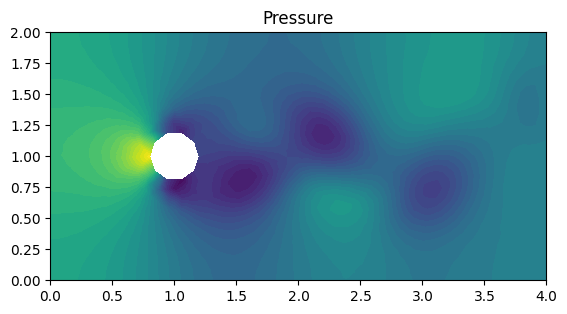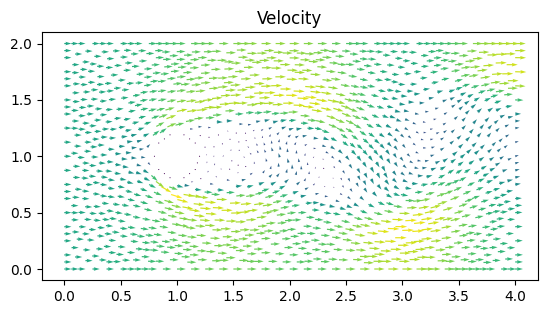

At the end :

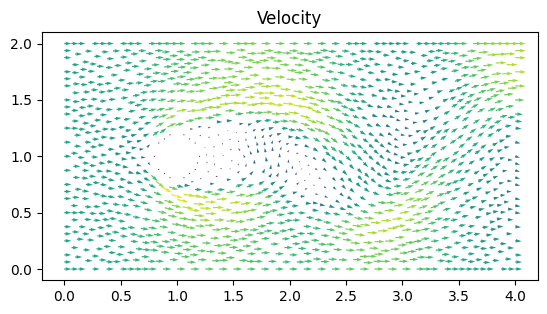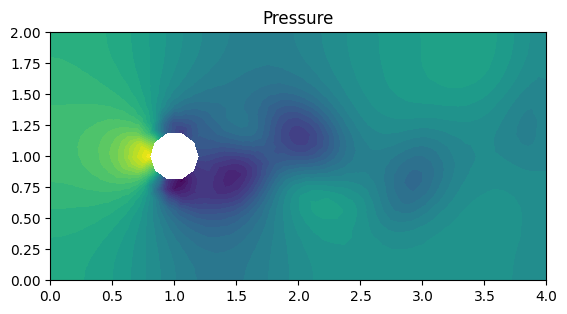

The pressure field matches the rotation component and the velocity field follows this structure too (with the vortices).

**From the observations, the flow becomes unsteady for Re=100.**

### **Re=1000**


At the beginning :

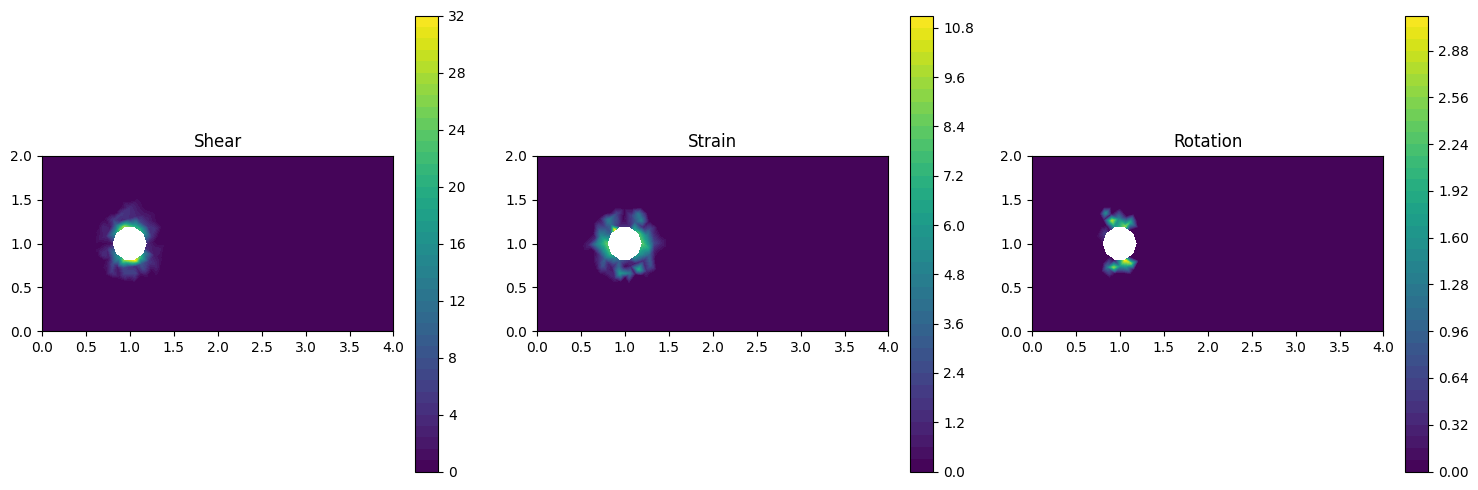

After some time :

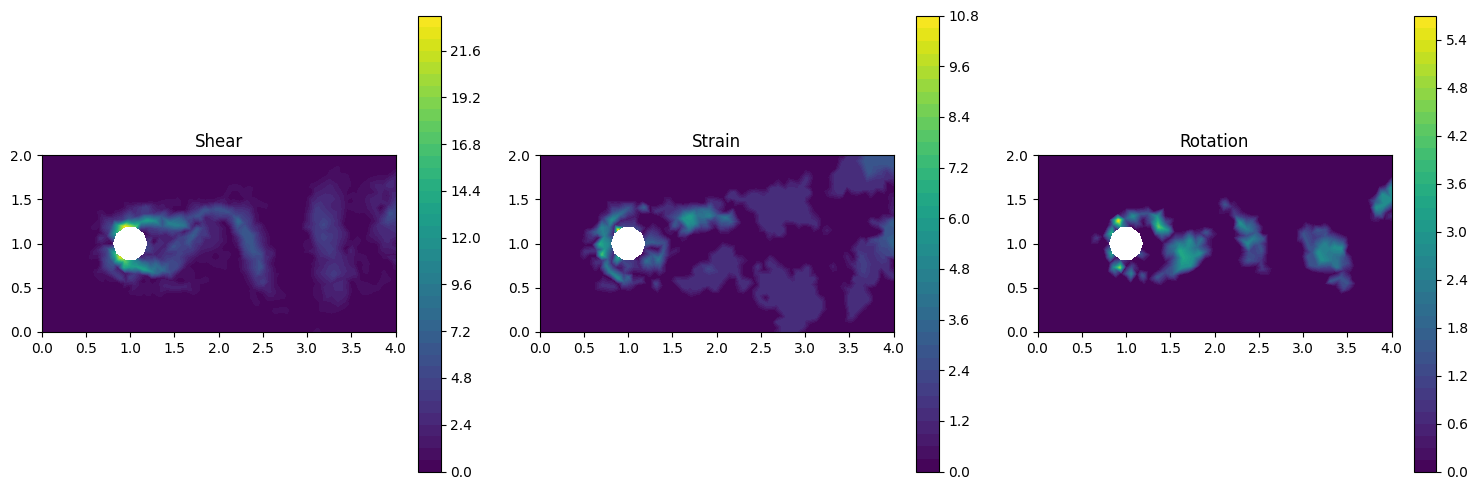

At the end :

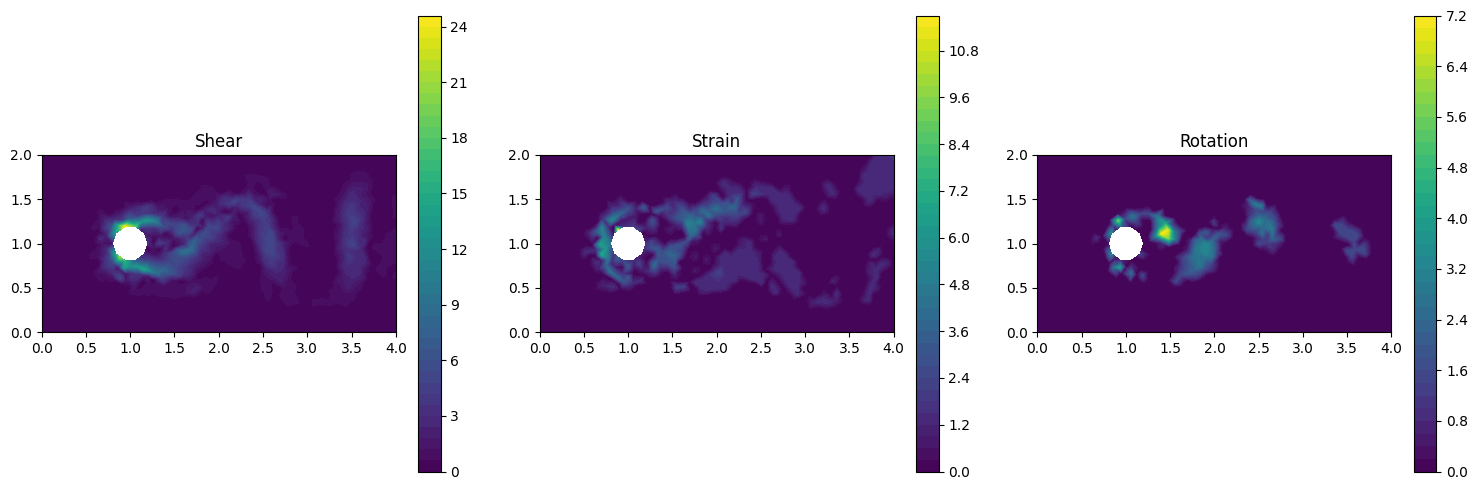

▶ For Re=1000, we clearly observe unsteadiness with vortices evolving and significant shear and strain components.

At the end :

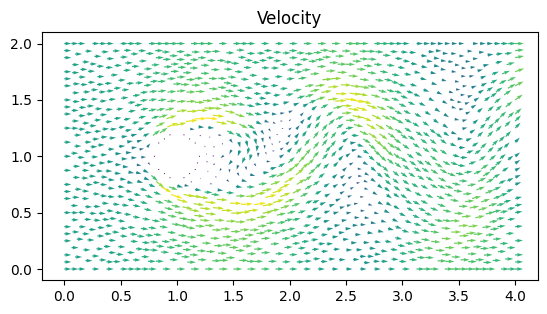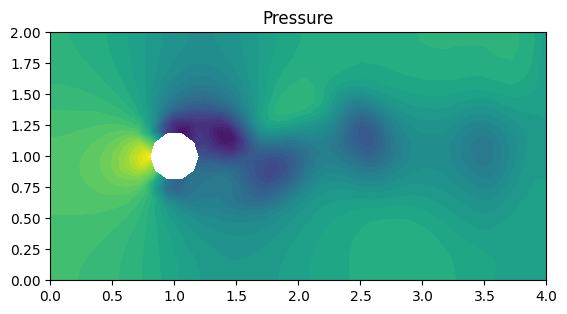

The velocity field and pressure fields follow the evolution of vortices and support the idea that the flow is unsteady.

▶ For Re=1000, the flow is unsteady as we still observe the vortices shedding.

# **2. Drag and lift coefficients**

For Re=1, there is a transient phase where there are small oscillations of cD and cL but the flow then reaches a stedy behavior without a **constant drag and lift**. The frequency is then **f=0** thus the Strouhal number is **St=0**.

However we can notice that the drag coefficient is dominant (cL is close to zero).

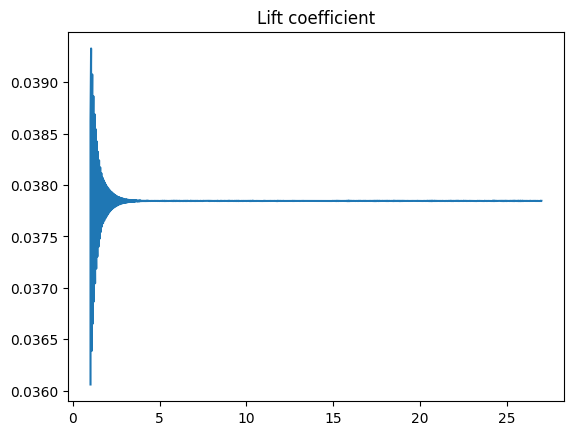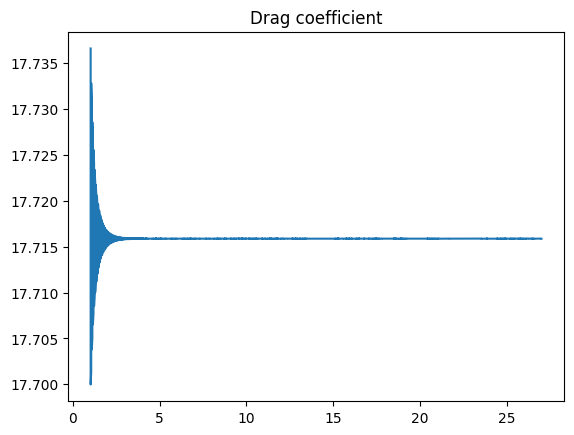

For Re=10, the flow reaches a steady behavior again thus there are no oscillations of the drag and lift coefficients. Then cL is close to zero here and cD is dominant. The frequency is f=0 thus Stouhal number is **St=0**.

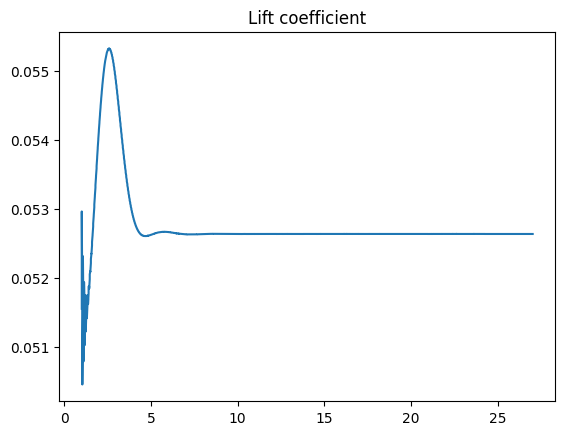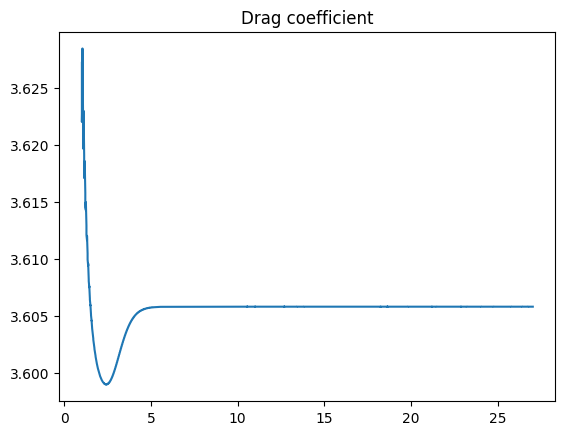

For Re=100, we have unsteadiness and we observe oscillations of cD and cL.
Here we can compute the Stouhal number St=fL/U thus St=fD (here). D=0.4 and f can be graphically determined.

We have f ≈ 7/15 (with 7 oscillations and 15s) and **St ≈ 0.4*7/15 ≈ 0.19**.

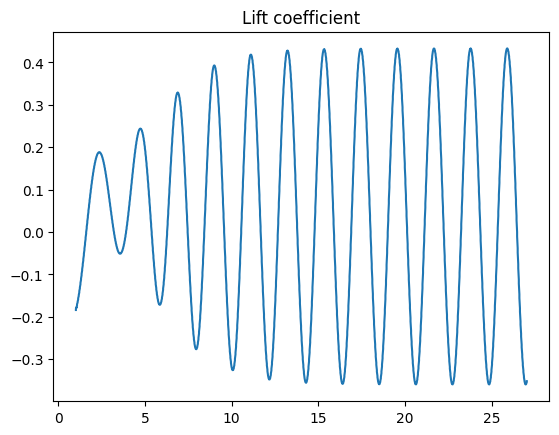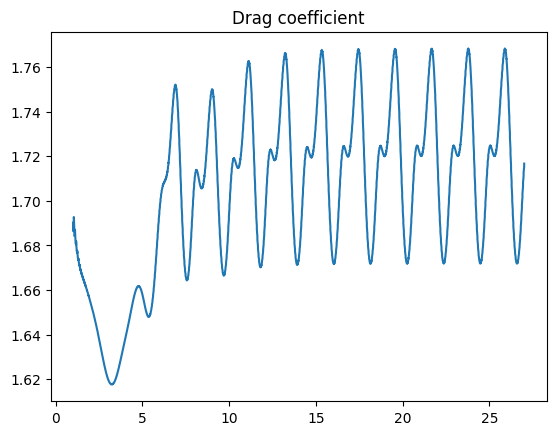

For Re=1000, we have unsteadiness and vortices thus we can observe oscillations of cD and cL. For the Strouhal number we have :

f ≈ 8/15 (with 8 oscillations and 15s) and **St ≈ 0.4*8/15 ≈ 0.21**.

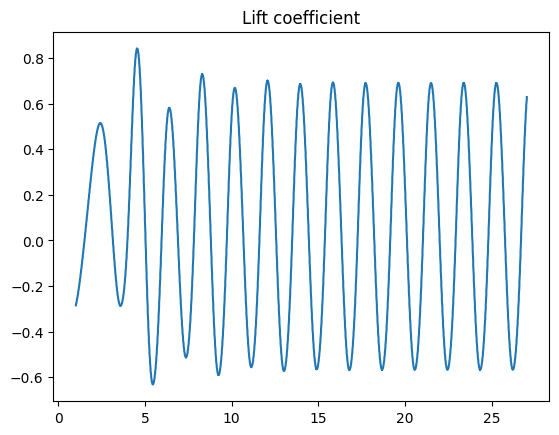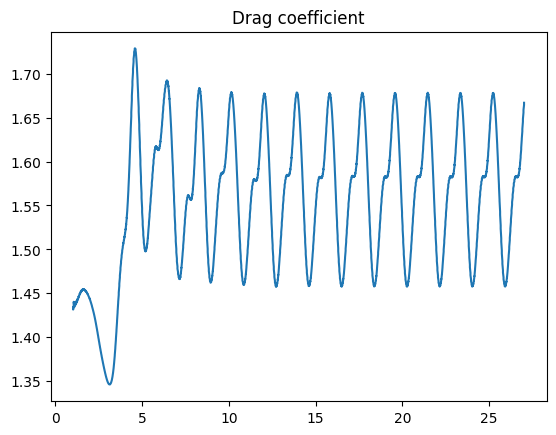


**We verify that the von Karman vortex street has a Strouhal number St=0.2.**

# **3. Mesh resolution**

Re=100 under the different mesh resolutions h=1/8, 1/16, 1/32

# **h=1/8**

For a coarse mesh we do not observe any rotation and von Karman vortex even though Re=100. The pressure field does not manage the vortices shedding. The drag and lift coefficient are not accurate and St=0 here.

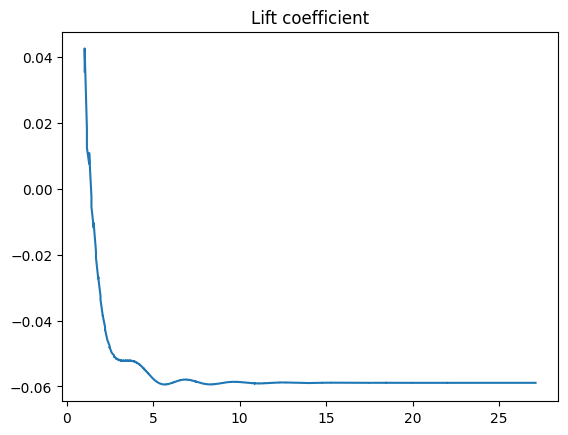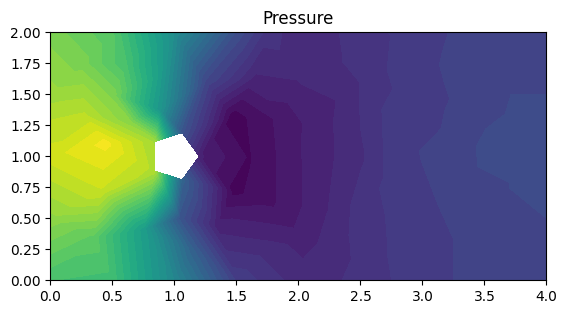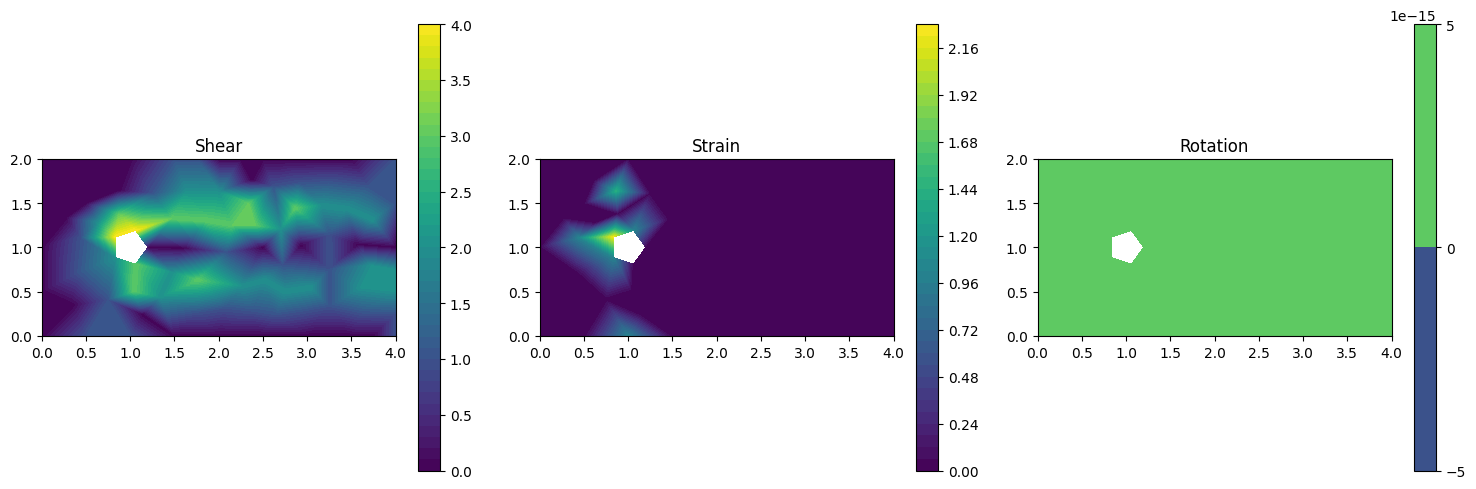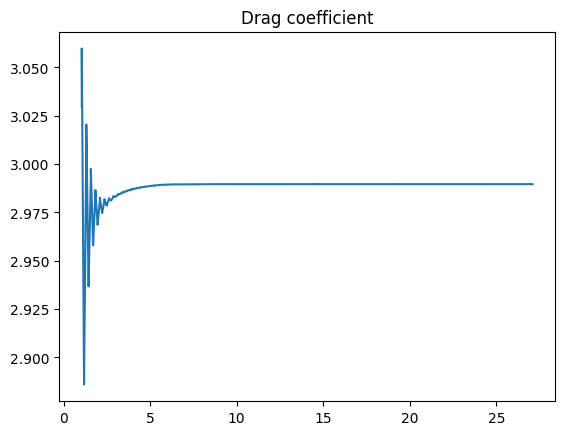

# **h=1/16**

For a thinner mesh, the vortex are detected, the rotation and pressure fiels manage to compute the phenomenon. However the drag and lift coefficient are still not really accurate.

Strouhal number can be computed as before : St=0.4f (here) and f ≈ 4/10. **Thus St ≈ 0.16. It is close to the result for h=1/32 we expected.**

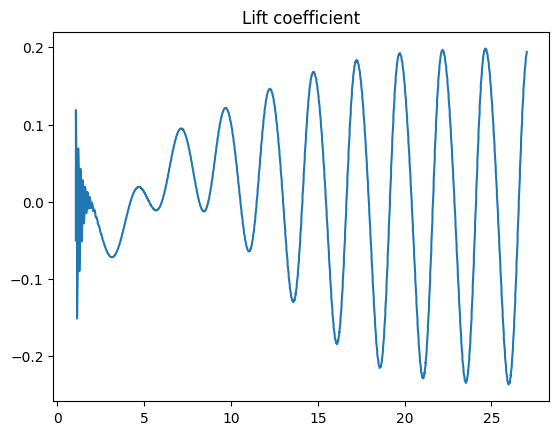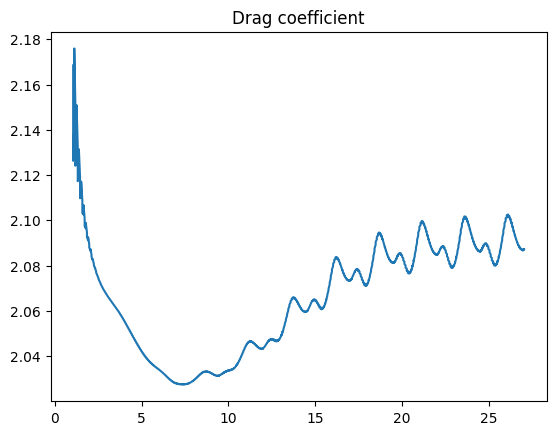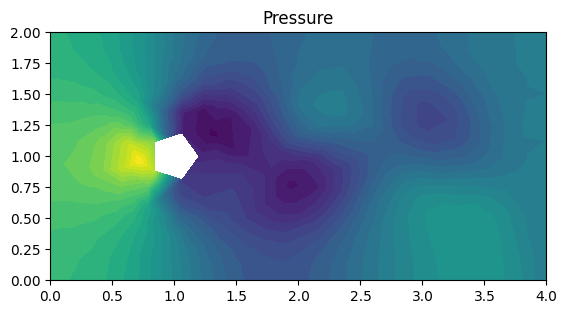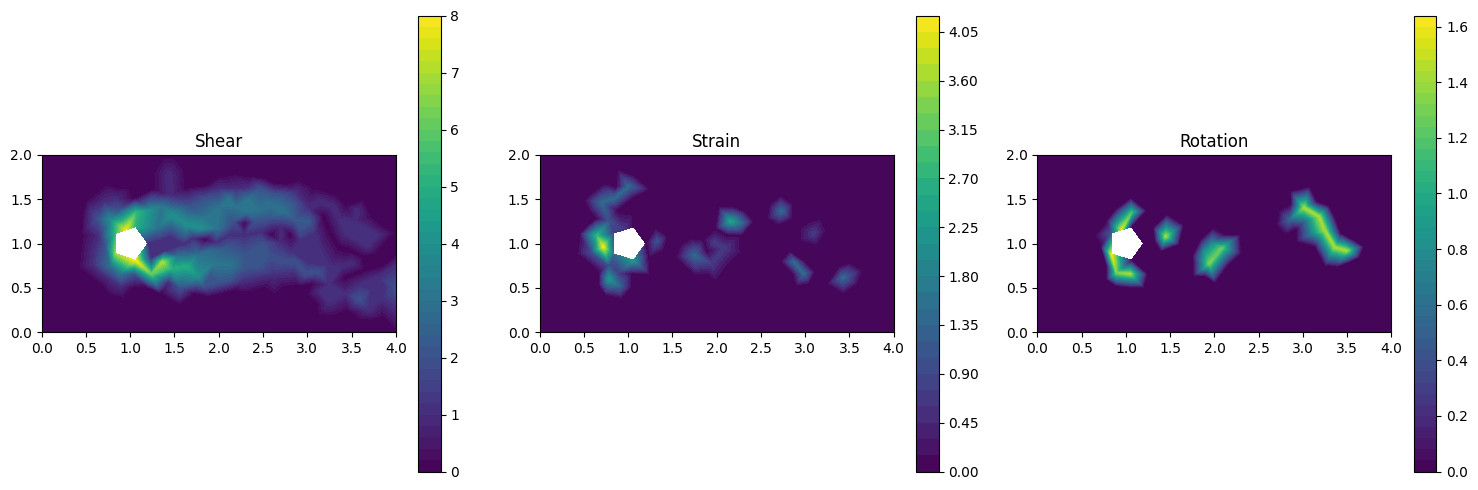

# **h=1/32**

This case was computed before. With this thin resolution we observe the von Karman vortex well at Re=100. The velocity, pressure and rotational fields accurately represent the phenomenon.

The drag and lift coefficients have easily detectable oscillations which enables to compute a St ≈ 0.19.

**We create a movie for Re=100 and h=1/32 with Paraview. We create the movie for the velocity and observe the unsteadiness.**